# Plotting sequence logos

The code in this tutorial is released under the [MIT License](https://opensource.org/licenses/MIT). All the content in this notebook is under a [CC-by 4.0 License](https://creativecommons.org/licenses/by/4.0/). 

In [1]:
import regseq.viz
import pandas as pd

import regseq.information
import numpy as np


#import regseq.find_region_original as find_region_original
import regseq.find_region as find_region

import matplotlib.pyplot as plt
%matplotlib inline

# Get svg graphics from the notebook
%config InlineBackend.figure_format = 'svg' 

For a detailed explanation of the steps leading to this notebook, as well as the experimental context, refer to the [Reg-Seq wiki](https://github.com/RPGroup-PBoC/RegSeq/wiki).

Previously we analyzed the datasets that can be obtained in a Reg-Seq experiment and using statistical inference methods to inferer how mutations at each base in a promoter sequence change gene expression, and we computed information footprints which we used to identify binding sites for repressors and activators. In this step, we are going to automatically identify significant binding sites and use the `logomaker` package to plot sequence logos of the identified sites.

First, let's look at the information footprint we created previously from an energy matrix computed by an MCMC algorithm with sufficient number of steps.

In [2]:
pd.read_csv("../data/inference_results/ykgEarabinosedataset_alldone_with_largeMCMC194", delim_whitespace=True)

,pos,val_A,val_C,val_G,val_T
0,0,0.014540,0.001685,-0.022539,0.006314
1,1,0.023509,-0.002869,-0.023115,0.002475
2,2,-0.003412,0.020748,-0.016885,-0.000451
3,3,0.009721,-0.001487,-0.020443,0.012209
4,4,-0.011957,-0.000411,0.021063,-0.008694
...,...,...,...,...,...
175,175,-0.003142,-0.006916,0.004624,0.005434
176,176,-0.006274,0.013448,0.010144,-0.017318
177,177,-0.000617,0.003695,0.005405,-0.008484
178,178,0.005982,-0.002930,0.008917,-0.011969


<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/mpathic_env/lib/python3.6/site-packages/matplotlib/pyplot.py'>

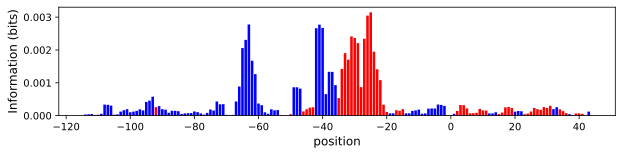

In [2]:
regseq.viz.footprint_from_emat("../data/inference_results/ykgEarabinosedataset_alldone_with_largeMCMC194", output_file=None, old_format=True, gene="ykgE", windowsize=3)

### Find significant regions

To identify significant regions, first we compute the information footprint. Therefore we use the function `regseq.information.emat_to_information` to compute the expression shift per position from an energy matrix, and then use `regseq.information.footprint` to compute the information footprint.

In [3]:
windowsize=1
arr = regseq.information.emat_to_information(
        "../data/ykgE/ykgEarabinosedataset_alldone_with_largeMCMC194", old_format=True, gene="ykgE")

info, _, signs = regseq.information.footprint(arr, windowsize=windowsize)

Note that we have the mutual information in the variable `info` and the sign of expression change in `signs`, we can proceed with finding significant regions. To do so, we first separate the information footprint between bases which increase and decrease expression. 

In [4]:
em = info
em_noabs = info * signs

pos_mat = np.zeros(160)
neg_mat = np.zeros(160)

# Separate activating and repressing bases
for q in range(len(em_noabs)):
    if em_noabs[q] > 0:
        pos_mat[q] = np.abs(em_noabs[q])
    else:
        neg_mat[q] = np.abs(em_noabs[q])

Next, we look for bases which have plenty of mutual information in the following bases, which is indicative that there is a binding site. The function `regseq.find_region.do_sum2` computes the sum of the mutual information of the following 15 base pairs. We need this average to use a threshold later. Let's look at a plot of the summed information of activating (`summedarr2`) and repressing mutated bases (`summedarr2_neg`)

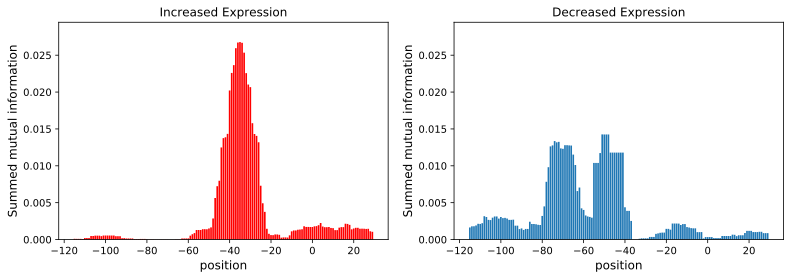

In [5]:
summedarr2 = regseq.find_region.do_sum2(pos_mat)
summedarr2_neg = regseq.find_region.do_sum2(neg_mat)

fig, ax = plt.subplots(1,2, figsize=(13, 4))
ax[0].bar(np.arange(-115, 30), summedarr2, color="red")
ax[0].set_xlabel("position",fontname='DejaVu Sans',fontsize=12)
ax[0].set_ylabel("Summed mutual information",fontname='DejaVu Sans',fontsize=12)
ax[0].set_title("Increased Expression")
ax[0].set_ylim([0, np.max([np.max(summedarr2), np.max(summedarr2_neg)])*1.1])

ax[1].bar(np.arange(-115, 30), summedarr2_neg)
ax[1].set_xlabel("position",fontname='DejaVu Sans',fontsize=12)
ax[1].set_ylabel("Summed mutual information",fontname='DejaVu Sans',fontsize=12)
ax[1].set_title("Decreased Expression")
ax[1].set_ylim([0, np.max([np.max(summedarr2), np.max(summedarr2_neg)])*1.1]);

There seems to be an repressor binding site around position -40 (relative to TSS), as we can see peak in the mutual information for increasing expression with mutations (mutations weaken the binding of the repressor, therefore increasing expression). However, keep in mind that what we are showing here is the summed information of the 15 following bases at each position, so a peak is indicative for the start of a binding site. In the plot on the right showing possible activator binding sites, we see two peaks. Below we walk through how to handle close peaks.

Next, we have to use a threshold to determine which segments are significant. 

To determine which threshold to use, we selected a training set of two genes with previously studied binding sites, DgoR (upstream site from the *dgoR* promoter) and CRP (from the *araAB* promoter), 2 genes with only RNAP sites including *hslU* (under heat shock) and *poxB*, as well as several genes we classified as inactive where no RNAP sites or other binding sites could be observed. These inactive genes included *hicB, mtgA, eco, hslU* (without heat shock), and *amiC*. We selected the threshold such that the RNAP sites and known binding sites were identified, while no binding sites were identified in the inactive regions. The threshold used in the following is 0.00025.

Below, we apply the threshold to each position, and call a position significant (assigning it the value 1), if the average mutual information of the following 15 bases exceeds the threshold. For positions where expression is decreased, we also store that information by assigning the value -1 to these positions. To visualze the process, we plot the same bar plot as above, and add the threshold.

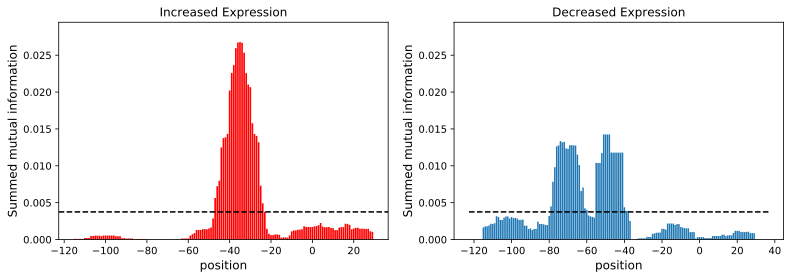

In [6]:
# Parameters
thresh = 0.00025
windowsize = 15
info_length = 160

# Significant bases increasing expression
is_significant = np.zeros(info_length-windowsize)

# Significant bases decreasing expression
is_significant_neg = np.zeros(info_length-windowsize)

# Check each base for significant segment
for i in range(info_length - windowsize):
    is_significant[i] = summedarr2[i] / windowsize > thresh 
    is_significant_neg[i] = summedarr2_neg[i] / windowsize > thresh 
    is_significant_neg[i] = is_significant_neg[i] *- 1


# Plot threshold
fig, ax = plt.subplots(1,2, figsize=(13, 4))
ax[0].bar(np.arange(-115, 30), summedarr2, color="red")
ax[0].set_xlabel("position",fontname='DejaVu Sans',fontsize=12)
ax[0].set_ylabel("Summed mutual information",fontname='DejaVu Sans',fontsize=12)
ax[0].set_title("Increased Expression")
ax[0].set_ylim([0, np.max([np.max(summedarr2), np.max(summedarr2_neg)])*1.1])
ax[0].plot(ax[0].set_xlim(), [0.00025*15, 0.00025*15], '--', color="black")


ax[1].bar(np.arange(-115, 30), summedarr2_neg)
ax[1].set_xlabel("position",fontname='DejaVu Sans',fontsize=12)
ax[1].set_ylabel("Summed mutual information",fontname='DejaVu Sans',fontsize=12)
ax[1].set_title("Decreased Expression")
ax[1].set_ylim([0, np.max([np.max(summedarr2), np.max(summedarr2_neg)])*1.1])
ax[1].plot(ax[0].set_xlim(), [0.00025*15, 0.00025*15], '--', color="black");

Next we need to identify the actual binding sites. Therefore we use the function `regseq.find_region.select_region`, which only takes the information if significance for each position (as well as gene name and growth condition, which are only used to generate the output) and checks for connected regions which exceed the threshold.

In [7]:
outdf_temp = regseq.find_region.select_region(is_significant, "ykgE", "arabinose")
outdf_temp2 = regseq.find_region.select_region(is_significant_neg, "ykgE", "arabinose")

Let's have a look at the results for possible repressor binding sited (`outdf_temp`).

In [8]:
outdf_temp

,gene,growth,feat_num,start,end,type
0,ykgE,arabinose,0,68,92,rep


Note, the function returnes positions relative to the first one, so to compare to the figures above, we have to subtract 115 to match the positions. Then we see that the region we found is between positions -47 and -23, which checks out which the figure above.

Next, we look at the result for activation binding sites (`outdf_temp2`).

In [9]:
outdf_temp2

,gene,growth,feat_num,start,end,type
0,ykgE,arabinose,0,36,56,act
1,ykgE,arabinose,1,60,78,act


So far we have only used averaged mutual information to identify significant regions. However, to find the actual locations, we need to identify individual bases which exceed the threshold. We are looking for the first and the last base in the identified regions which ecceed this threshold. To do that, we can use the function `regseq.find_region.find_edges`. Below we define a DataFrame (`outdf`) prior to using the function, where we are going to store the results in (combining results from activator and repressor binding sites).

In [10]:
outdf = pd.DataFrame(columns=['gene', 'growth', 'feat_num', 'start', 'end', 'type'])
growth="arabinose"
counter = 0
for i,row in outdf_temp.iterrows():
    start = row['start']
    end = row['end']
    newstart,newend = regseq.find_region.find_edges(pos_mat, start, end)
    outdf.loc[counter,['gene','growth','feat_num','start','end','type']] =\
        [row['gene'],growth,row['feat_num'],newstart,newend,row['type']]
    counter = counter + 1
for i,row in outdf_temp2.iterrows():
    start = row['start']
    end = row['end']
    newstart,newend = regseq.find_region.find_edges(neg_mat, start, end)
    outdf.loc[counter,['gene','growth','feat_num','start','end','type']] =\
        [row['gene'],growth,row['feat_num'],newstart,newend,row['type']]
    counter = counter + 1
    
outdf

,gene,growth,feat_num,start,end,type
0,ykgE,arabinose,0,70,99,rep
1,ykgE,arabinose,0,41,67,act
2,ykgE,arabinose,1,60,78,act


Looking at the activator sites, we can see that there are two distinct regions which are close together. This is indicative for a joint binding site with an uninformative section in the center. To look for these gaps, we use the function `regseq.find_region.merge_growths`. This function can also merge information about binding sites from different growth conditions. However, for this example we are only considering one growth condition.

In [11]:
output_merged = regseq.find_region.merge_growths(outdf, windowsize, info_length=info_length)

In [12]:
output_merged

,gene,feat_num,start,end,type
0,ykgE,0,41,78,act
1,ykgE,0,70,99,rep


Now we found two significant regions in the promoter region. The activating site is the RNAP binding site, which has a slightly overlapping repressor binding site. Note that in cases of overlapping sites, the edges are not well defined, since a mutation is both decreasing at increasing expression at the same time. To interpret the results and compare to information footprints, don't forget that the positions above are relative to the first position in the sequence and not the TSS.

All the steps we did above are combined into a single function, `regseq.find_region.find_region`, which takes the statistical inference results as input, as well as an argument which tells the function if the file is in the old format, (file name does not end with `.csv`), the name of the gene, the growth condition, and the threshold value.

In [13]:
regions = find_region.find_region("../data/inference_results/ykgEarabinosedataset_alldone_with_largeMCMC194", "ykgE", "arabinose", old_format=True)
regions

,gene,feat_num,start,end,type
0,ykgE,0,-74,-37,act
1,ykgE,0,-45,-16,rep


This function returns the positions relative to the TSS. Let's extract the start and end of the RNAP and produce a logo.

In [14]:
target_start = regions.loc[0, 'start']
target_end = regions.loc[0, 'end']

We first need to find the proper scaling factor for conversion to information logo. Empirically, it is known
that binding sites have approximately 1 bit of information per base pair. Logos are then produced using the package `logomaker`. To produce logos, we can use the function `regseq.viz.logo`. As input we need to give the file path to the energy matrix inferred previously, as well as the range of the sequence that we wish to produce the logo for, `limit`. As before, we also tell the function that the file format.

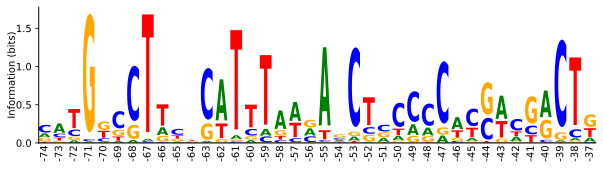

In [20]:
p = regseq.viz.logo("../data/ykgE/ykgEarabinosedataset_alldone_with_largeMCMC194", limit=(target_start, target_end), old_format=True)

These logos can be used for nice figures in papers. (Here needs to be a nice conclusion on what to do with the figures, Bill please add a short note.)

Finally, here are the versions of packages used in this notebook. To display the versions, we are using the Jupyter Lab extension `watermark`, which can be found [here](https://github.com/rasbt/watermark).

## Computing environment

In [16]:
%load_ext watermark
%watermark -v -p jupyterlab,numpy,pandas,logomaker,matplotlib

CPython 3.6.9
IPython 7.13.0

jupyterlab not installed
numpy 1.18.1
pandas 1.0.3
logomaker 0.8
matplotlib 3.1.3
